In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools
import statsmodels.api as sm
from itertools import product
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [3]:
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/Датасеты/DFBristol.xlsx")
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Store,Date,Sales,MON_DATE
0,25,2015-06-30,16572,2015-06-01
1,94,2015-06-30,10792,2015-06-01
2,116,2015-06-30,9230,2015-06-01
3,155,2015-06-30,11461,2015-06-01
4,174,2015-06-30,8327,2015-06-01


In [4]:
# Определяем метрику
def wape(y_true, y_pred):
    return round(np.mean(np.abs((y_true - y_pred) / y_true)) * 100, 2)

store_numbers = df.Store.unique()

store_results = []

# Проходимся по каждому магазину
for store_number in store_numbers:
    df2 = df[df["Store"] == store_number].groupby("MON_DATE", as_index = False)["Sales"].mean()

   # Определяем выборку, на которой будем обучаться
    train_len = int(0.8 * len(df2))
    y = df2.iloc[:train_len]["Sales"].to_numpy().reshape(-1, 1)
    k = len(df2) - train_len

    # Определяем пул параметров, по которым будем итерироваться
    param_grid = [(p1, p2, p3, p4, p5, p6, 12) for p1, p2, p3, p4, p5, p6 in product(range(3), repeat=6)]
    #param_grid = [(p1, p2, p3, p4, p5, p6, k) for p1, p2, p3, p4, p5, p6 in product(range(5), repeat=6) for k in range(2, 13)]

    best_wape = float('inf')
    best_params = None

    # Проходимся по каждому набору параметров
    for params in param_grid:
        try:
            model = sm.tsa.statespace.SARIMAX(y, order=params[:3], seasonal_order=(params[3], params[4], params[5], params[6]), enforce_invertibility=False, enforce_stationarity=False)
            model_fit = model.fit(maxiter=1000)
            y_pred = model_fit.forecast(steps=k)

            # Считаем метрику
            wape_value = wape(df2.iloc[train_len:]["Sales"].values, y_pred)

            if wape_value < best_wape:
                best_wape = wape_value
                best_params = params

        except Exception as e:
            print(f'Error: {e}')

    # Делаем прогноз с помощью набора параметров, при котором метрика минимальна
    model = sm.tsa.statespace.SARIMAX(y, order=best_params[:3], seasonal_order=(best_params[3], best_params[4], best_params[5], best_params[6]), enforce_invertibility=False, enforce_stationarity=False)
    model_fit = model.fit(maxiter=1000)
    y_pred = model_fit.forecast(steps=k + 1)

    # Считаем выручку на прогнозный месяц
    revenue = round(y_pred[-1] * 31)

    # Создаем датафрейм с прогнозом по каждому магазину
    df_result = pd.DataFrame({
        "Store": [store_number],
        "Minimum_WAPE": [best_wape],
        "Revenue_next_month": [revenue],
        "Best_param_SARIMAX": [str(best_params)]
    })

    store_results.append(df_result)

df_final = pd.concat(store_results).reset_index()
df_final.drop('index', axis=1, inplace=True)
print(df_final)

    Store  Minimum_WAPE  Revenue_next_month      Best_param_SARIMAX
0      25          2.25              345046  (1, 1, 2, 0, 0, 0, 12)
1      94          1.62              235298  (1, 2, 2, 0, 1, 0, 12)
2     116          0.96              226346  (1, 1, 2, 0, 1, 2, 12)
3     155          1.17              225740  (2, 1, 2, 1, 0, 1, 12)
4     174          3.69              192380  (2, 1, 2, 0, 0, 0, 12)
5     192          3.23              409732  (0, 1, 1, 0, 0, 0, 12)
6     325          2.29              186931  (0, 0, 0, 1, 0, 1, 12)
7     349          1.28              278759  (1, 1, 1, 1, 0, 0, 12)
8     376          2.71              264041  (0, 1, 1, 0, 0, 0, 12)
9     394          1.27              276194  (0, 1, 2, 1, 0, 1, 12)
10    417          1.18              218895  (0, 0, 0, 1, 0, 0, 12)
11    438          1.86              182319  (1, 2, 2, 1, 0, 1, 12)
12    473          1.78              107526  (0, 1, 1, 1, 0, 1, 12)
13    484          3.09              235337  (0,

In [5]:
df_final["Minimum_WAPE"].median()

1.885

In [ ]:
#df_final.to_csv('Bristol3.csv')

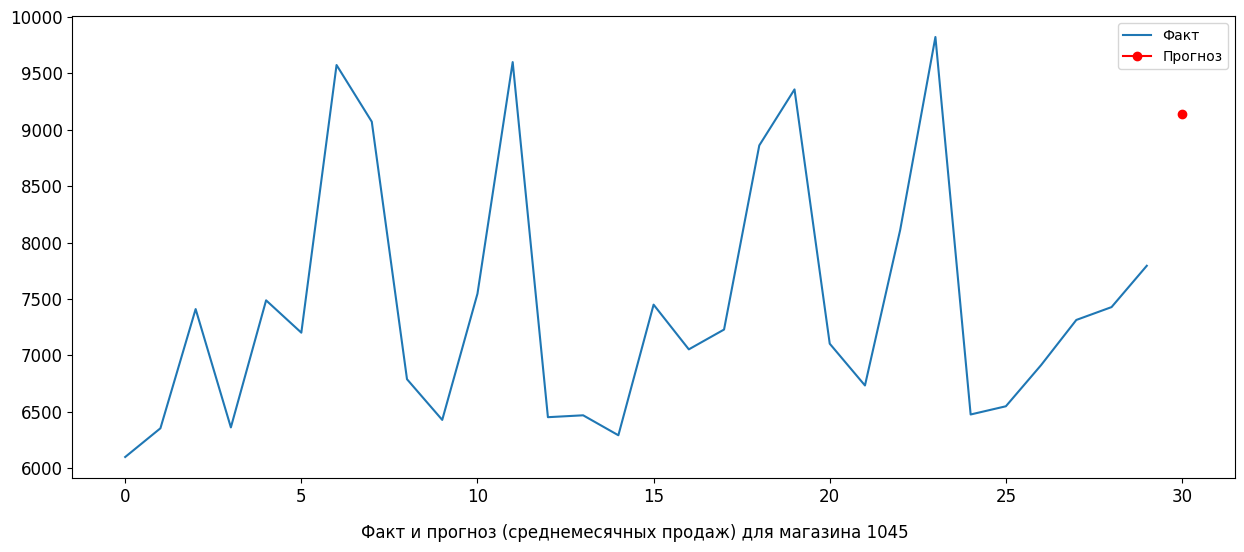

In [31]:
def plot_sales(store):
    df3 = df[df["Store"] == store].groupby("MON_DATE", as_index = False)["Sales"].mean() #Факт
    predict_mean = (df_final[df_final["Store"] == store]["Revenue_next_month"])/31 # Прогноз

    plt.figure(figsize=(15,6))
    plt.plot(df3["Sales"], label='Факт')
    plt.plot(range(len(df3), len(df3) + 1), predict_mean, color='red', marker='o', label='Прогноз')
    plt.figtext(0.5, 0.01, f'Факт и прогноз (среднемесячных продаж) для магазина {store}', ha='center', fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend()
    plt.show()
plot_sales(1045)